# Jack's Car Rental 
#### Figure 4.2


Detailed analysis of the problem in Aditya Rastogi's blogpost 
[Elucidating Policy Iteration in Reinforcement Learning — Jack’s Car Rental Problem](https://towardsdatascience.com/elucidating-policy-iteration-in-reinforcement-learning-jacks-car-rental-problem-d41b34c8aec7)

His repo https://github.com/thunderInfy/JacksCarRental

Good ideas how to speed up code execution in Yang Zhang's repo https://github.com/zy31415/jackscarrental

Those looking for an explanation of the  probabilities calculation should look below cell 4.

In [1]:
import copy
import math
import time
import itertools

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Constants and global variables:

In [2]:
# maximum car number at each location
MAX_CARS = 20

# all possible states -- cartesian product of 21 (as 0 is a possible state)
STATES = tuple(itertools.product(range(MAX_CARS + 1), repeat=2))

# maximal number of cars to move overnight
MAX_MOVE = 5

# policy evaluation accuracy
THETA = 1e-2

# initialise values and policy
# values as 2d array axis0 and axis1 (x, y) being the numbers of cars at first and second locations respectively
values = np.zeros((MAX_CARS + 1,) * 2)

# action chosen at each state (integers from -5 to 5)
policy = np.zeros((MAX_CARS + 1,) * 2, dtype=int)

# rewards and transition probabilities will be precalculated
# 4d array for cumulative reward for transition from one state (x, y) to another (x1, y1)
rewards = np.zeros((MAX_CARS + 1, ) * 4)

# 4d array for transition probabilities between all states
transition_probs = np.zeros((MAX_CARS + 1, ) * 4)

From the book: "...the number of cars requested and returned at each location are Poisson random variables, meaning that the probability that the number is $n$ is $\frac{\lambda^n}{n!}e^{-\lambda}$, where $\lambda$ is the expected number":

In [3]:
def poisson_prob(n, _lambda):
    """The probability of k occurrences of a random variable having poisson distribution with expected value mu

    :param n: number of occurrences
    :type n: int
    :param _lambda: expected value
    :type _lambda: int
    :return: probability of n
    :rtype: float
    """
    return math.exp(-_lambda) * pow(_lambda, n) / math.factorial(n)

As it is not stated how many cars may be requested or returned we assume it can be any natural number. The expectations for request are 3 and 4 and for return are 3 and 2 at the first and second locations respectively. Given that, probabilities for any number of cars above 11 is less than 0.001:

In [4]:
for _lambda in (2, 3, 4):
    y = np.array([poisson_prob(n, _lambda) for n in range(21)])
    y1 = np.where(y > 0.001)
    print(f'if lambda is {_lambda}, max car number is {np.max(y1)}')

if lambda is 2, max car number is 7
if lambda is 3, max car number is 9
if lambda is 4, max car number is 11


We could calculate transition probabilities and rewards for all possible requests and returns below those numbers and get expected values that are close enough to the correct ones to find optimal policy. But Yang Zhang in his [repo](https://github.com/zy31415/jackscarrental) uses the approach to calculate exact probabilities for <em>any</em> number of cars requested or returned.

Consider we have $x$ cars at the first location. All requests from $0$ to $x$ cars have probabilities according to poisson distribution:

In [5]:
# let x be 5
x = 5

# expectation of the request at the first location
_lambda = 3

request_probabilities = [poisson_prob(n, _lambda) for n in range(x + 1)]
for n, prob in enumerate(request_probabilities):
    print(f'probability that {n} cars will be requested is {prob}')

probability that 0 cars will be requested is 0.049787068367863944
probability that 1 cars will be requested is 0.14936120510359183
probability that 2 cars will be requested is 0.22404180765538775
probability that 3 cars will be requested is 0.22404180765538775
probability that 4 cars will be requested is 0.16803135574154082
probability that 5 cars will be requested is 0.10081881344492448


In this situation ($x=5$) we get the same reward ($50$ dollars) and move to the same new state ($x=0)$ after all requests above $5$. The probability to get any request above $5$ is $1 - \sum_{n=0}^{5}p(n)$. So if we sum the probability that $5$ will be requested and the probability that any number above $5$ will be requested, we will get the probability to get the reward $50$ and move to the state $x=0$:

In [6]:
request_probabilities[-1] += 1 - sum(request_probabilities)
print(f'Probability that 5 or more cars will be requested is {request_probabilities[-1]}')

Probability that 5 or more cars will be requested is 0.18473675547622792


The logic behid calculating returns is the same, but we need to sum all probabilities from $0$ to $20 - x$. If $x=5$ the return of $15$ cars and any number above that will move us to the same new state $x=20$. Let's calculate the series of probabilities for all possible car numbers and expectations:

In [7]:
poisson_probs = dict()
for _lambda in (2, 3, 4):
    for cars_num in range(MAX_CARS + 1):
        poisson_probs[cars_num, _lambda] = [poisson_prob(k, _lambda) for k in range(cars_num + 1)]
        poisson_probs[cars_num, _lambda][-1] += 1 - sum(poisson_probs[cars_num, _lambda])

Now we can precalculate all transition probabilities and respective rewards. It takes some time, but speeds up the policy evaluation.

In [8]:
t0 = time.perf_counter()

# x and y state for numbers of cars at first and second locations respectively
for x, y in STATES:
    print('\r', f'Precalculating rewards and transition probabilities for state {x, y}', end=' ')
    # can't request more cars then available at either location
    for request_x, req_quest in itertools.product(range(x + 1), range(y + 1)):
        # cars left after request
        x1, y1 = x - request_x, y - req_quest

        # probability for the number of requested cars at both locations
        prob_req = poisson_probs[x, 3][request_x] * poisson_probs[y, 4][req_quest]
        # $10 for each car rented

        reward = (request_x + req_quest) * 10
        # can't return more than 20 minus number of cars left (cars over 20 disappear from the problem)
        for return_x, return_y in itertools.product(range(21 - x1), range(21 - y1)):
            # cars on both locations after return
            x2, y2 = x1 + return_x, y1 + return_y

            # probability for the number of cars returned to both locations
            prob_ret = poisson_probs[20 - x1, 3][return_x] * poisson_probs[20 - y1, 2][return_y]

            # probability of this particular transition from (x, y) to (x2, y2)
            prob_product = prob_req * prob_ret

            # update reward for (x, y) to (x2, y2) transition
            rewards[x, y, x2, y2] += reward * prob_product

            # update probability of (x, y) to (x2, y2) transition
            transition_probs[x, y, x2, y2] += prob_product

t1 = time.perf_counter()
print('done in ', round(t1 - t0, 3), 'seconds')

 Precalculating rewards and transition probabilities for state (20, 20) done in  15.773 seconds


Remaining steps are pretty straightforward. The only trick is that we had to precalculate transition probabilities itself and the products of rewards and transition probabilities separately to get the correct result. If we expand brackets in Bellman equation we get:

$$
\sum_{s', r}p(s',r|s,a)[r + \gamma V(s')] = \sum_{s', r}p(s',r|s,a)r + \gamma \sum_{s', r}p(s',r|s,a)V(s') = \\ \sum_{s', r}p(s',r|s,a)r + \gamma \sum_{s'}p(s'|s,a)V(s')
$$

In cell 8 we calculate $\sum_{s', r}p(s',r|s,a)r$ when we update rewards, and $\sum_{s'}p(s'|s,a)$ when we update transition probabilities.

 policy iteration  4

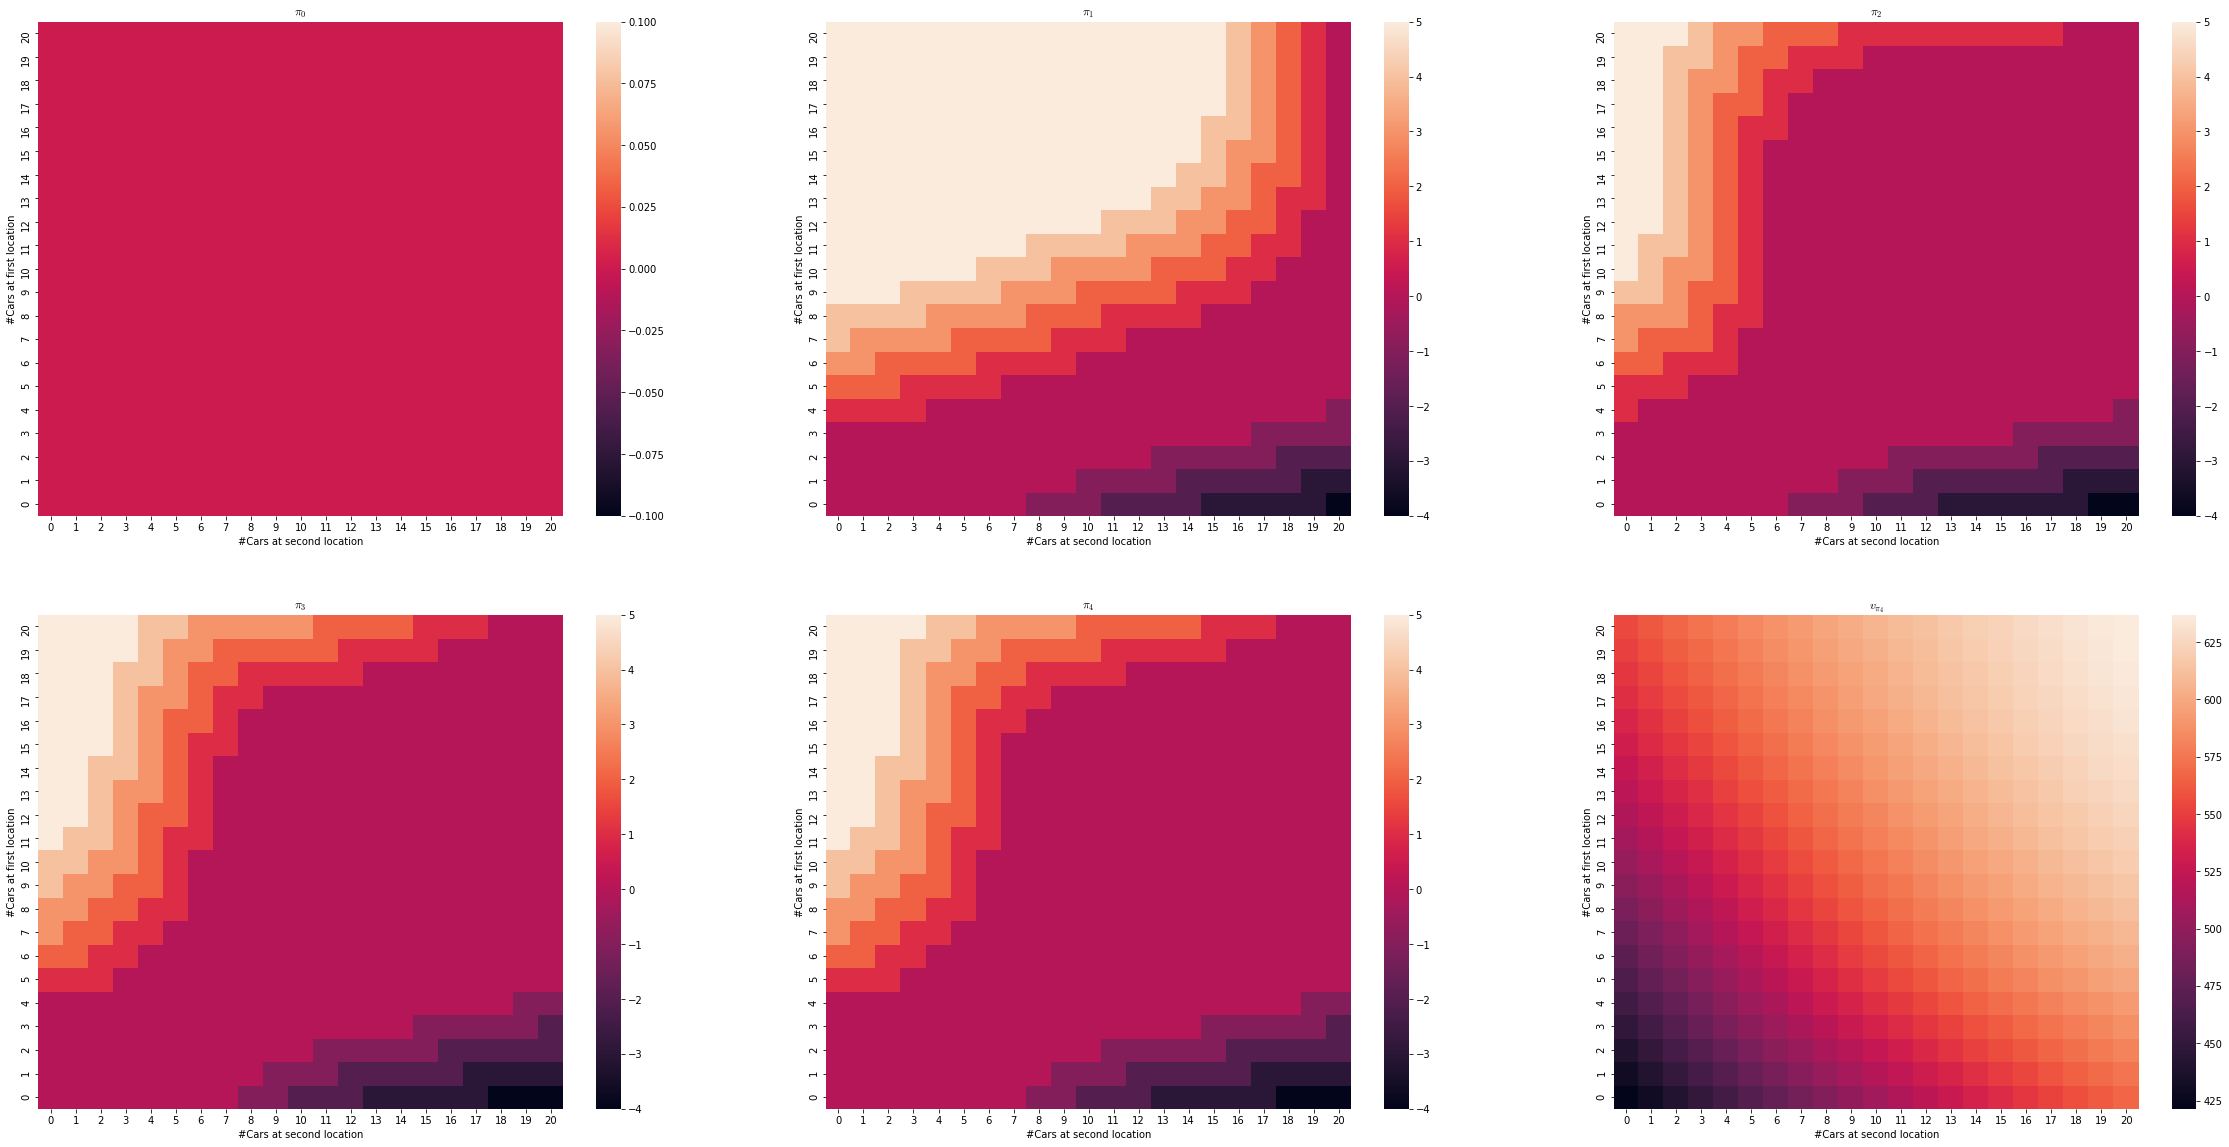

In [9]:
def expected_value(values, state, action, discount=0.9):
    """Calculate expected value for a given action

    :param state: state which value is updated
    :type state: tuple
    :param action: action taken in this state
    :type action: int
    :param discount: discount
    :type discount: float
    :return: new value
    :rtype: float
    """
    x, y = state

    # move cars overnight, actions are validated during the policy improvement
    x, y = min(x - action, 20), min(y + action, 20)

    # pay $2 for each moved car
    new_value = -2 * abs(action)

    # Bellman equation
    new_value += np.sum(rewards[x, y]) + np.sum(transition_probs[x, y] * values) * discount

    return new_value


def argmax(iterable):
    """Returns the index of the maximum element for python built-in iterables (e.g. lists or tuples).
    Turns out to be faster than numpy.argmax on low-dimensional vectors.

    :param iterable iterable: The vector in which to find the index of the maximum element
    :return: Maximum element index
    :rtype: Int
    """
    return max(range(len(iterable)), key=lambda x: iterable[x])


def policy_evaluation():
    """Policy evaluation implementation (step 2 of algorithm at page 80)

    :return: None
    """
    delta = 1
    while delta > THETA:
        delta = 0
        old_values = copy.deepcopy(values)
        for state in STATES:
            values[state] = expected_value(old_values, state, policy[state])
            delta = max(delta, abs(values[state] - old_values[state]))


def policy_improvement():
    """Policy improvement implementation (step 3 of algorithm at page 80)

    :return: None
    """
    policy_stable = True
    for state in STATES:
        old_action = policy[state]

        # get all possible actions
        x, y = state
        actions = range(-min(y, MAX_MOVE), min(x, MAX_MOVE) + 1)

        # list of action values
        action_values = [expected_value(values, state, action) for action in actions]

        # optimal action
        policy[x, y] = actions[argmax(action_values)]

        if old_action != policy[state]:
            policy_stable = False

    return policy_stable


def heatmap(data, title, axes, iteration):
    """Plot the heatmap for policy or values

    :param data:
    :param title:
    :param axes:
    :param iteration:
    :return:
    """
    h = sns.heatmap(data, ax=axes[iteration])
    h.set_ylabel('#Cars at first location')
    h.set_xlabel('#Cars at second location')
    h.set_title(title)
    h.invert_yaxis()
    plt.rc('mathtext', fontset="cm")


def policy_iteration():
    """Policy iteration implementation from RL book page 80

    :return: None
    """
#     precalculate()

    # plotting
    fig, axes = plt.subplots(2, 3, figsize=(40, 20))
    # plt.subplots_adjust(wspace=0.1, hspace=0.2)
    axes = axes.flatten()

    iteration = 0
    policy_stable = False
    while not policy_stable:
        print('\r', 'policy iteration ', iteration, end='')
        # plot policy
        policy_title = r'$\pi_{}$'.format(iteration)
        heatmap(policy, policy_title, axes, iteration)

        # step2
        policy_evaluation()

        # step3
        policy_stable = policy_improvement()

        iteration += 1

    # plot values
    value_title = r'$v_{\pi_4}$'
    heatmap(values, value_title, axes, iteration)


if __name__ == '__main__':
    policy_iteration()
    plt.show()
